## Fouled-off pitches
**What kinds of pitches are fouled off?**

How do fouled-off pitches differ from called/swinging strikes, or other pitch outcomes?

Is it possible to discern what types of pitches might get fouled off?

We can using machine learning algorithms to to train a **pitch outcome classifier**, then see how that model performs on a set of previously-unseen pitches.

What features might matter in determining whether a pitch is fouled off or not? We'll consider most of the features in the PITCHf/x dataset, but I'd guess that some important features would be: Ball/strike count, pitch type, pitch location, pitch velocity, etc.

In [1]:
# Import the necessary packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *
%matplotlib inline

In [2]:
# PITCHf/x data from 2016 Jun 1–3, parsed using the `pfx_parser_csv.py` script
data = pd.read_csv('edited_pitch_table.csv')

In [ ]:
data.head()     # To see what the data looks like

In [ ]:
list(data)     # Returns all column headers

In [ ]:
data.shape
# 64 features
# 12,134 samples (pitches) in this three day period

In [ ]:
#Split dataset into fouls and not-fouls
thefouls = data[data['pitch_res'] == 'F']
notfouls = data[data['pitch_res'] != 'F']
print('Fouls: ', thefouls.shape, 'Not Fouls: ', notfouls.shape)
# 2050 pitches were fouled off, 10,084 were not fouled off, unbalanced dataset.

Possible approaches:
1. Focus on fouled-off pitches, do K-means clustering do identify types of situations that lead to fouled-off pitches
2. Try to classify pitches as fouled or not-fouled, then investigate feature importance

The first approach is very interesting, but it ignores pitches that aren't fouled off, and so we don't get to see what's really distinct about fouled-off pitches.

So I like the second approach. Let's use a classification algorithm, starting with Random forests, and train a model that distinguishes the features of fouled-off vs. not-fouled-off pitches.

### Encoding the categorical variables

Several features are categorical, so they need to be encoded as 0/1s instead, for each possible value (that's the only input that these algorithms allow for).

In [ ]:
# Which features are categorical?
X.dtypes
# Pitcher hand, batter hand, pitch sequence, pitch type, pitch type sequence

In [3]:
# Use pd.get_dummies() to encode these categorical variables
catcols = ['pit_hand_cd', 'bat_hand_cd', 'pitch_type']
hots = pd.get_dummies(data, columns=catcols, prefix = catcols)

**Pitch sequence** (balls/strikes/etc.) **and pitch type sequence** (fastball/slider/etc.) **are VERY challenging to encode, since there's so many different possible sequences.** I'm going them leave them out of this analysis for now, even though they're undoubtedly critical to this problem.

What could be done about them in future?

Probably would involve something like a graph/network, or alternatively a much more enormous dataset. Either way, this is something worth keeping in mind and working on further.

In [ ]:
# Some rows have missing values, so drop them
hots = hots.dropna()
hots.shape    # 20 samples dropped, due to the encoding, not sure why?

In [5]:
# Split data into X (pitch features) and y (pitch outcomes)
y = hots['pitch_res']
# X needs to exclude the old now-encoded columns, but also stuff like the gameID, teamIDs, etc...
dropcols = [
    'retro_game_id',
    'year',
    'st_fl',
    'regseason_fl',
    'playoffs_fl',
    'game_type',
    'game_type_des',
    'game_id',
    'home_team_id',
    'home_team_lg',
    'away_team_id',
    'away_team_lg',
    'interleague_fl',
    'park_name',
    'park_lock',
    'pitch_seq',      # Too difficult to encode, unfortunately...
    'pa_terminal_fl',
    'pa_event_cd',
    'pitch_res',
    'pitch_des',
    'pitch_id',
    'pitch_type_seq',    # Too difficult to encode, unfortunately...
    'sv_id',
    'x', 'y',     # Older, less useful PitchFX features, now replaced by 'px' and 'pz'
    'y0'          # Distance between the pitcher's release point and home plate, held constant by definition in the PitchFX data
]
X = hots.drop(dropcols, axis=1)
print('X: ', X.shape, 'y: ', y.shape)

X:  (12114, 52) y:  (12114,)


In [6]:
# Let's focus on pitches that are fouled-off, vs. all other pitches and their outcomes
# Use pd.get_dummies() again to easily draw out the fouled-off pitches
possres = list(set(y))
outcomes = pd.get_dummies(y, columns=possres)
fouls = outcomes['F']

### Rebalancing the data

Most pitches are NOT fouled off. A model that just predicts 'not-foul' for every single pitch would appear to be accurate at first glance, but of course is very faulty.

So we'll have to **rebalance the data**. We could create a dataset with equal numbers of fouled-off and not-fouled off pitches, by creating duplicates and/or eliminating samples respectively.

In this case, I don't feel comfortable with those approaches, so instead, we'll **apply weights to the pitch outcomes**. If the model accurately predicts a fouled-off pitch, that correct prediction is rewarded based on how scarce fouled-off pitches are. This is easily implemented in Scikit-learn's Random forest classification function.

In [7]:
'''
IMPORTANT: Create sample weights to rebalance the data!
Most pitches are NOT fouled off, and we don't want the model to guess
'''
numnotfoul = len(fouls[fouls == 0])
numfoul = len(fouls[fouls == 1])
coefweight = numnotfoul / numfoul
print(coefweight)   # ~4.92x more not-fouls than fouls (will differ slightly with each train/test split)
sampweight = fouls.replace(0, coefweight)    # Rather than 0/1, the outcomes are now 0/4.92

4.917928676111383


In [8]:
# Split the dataset into a training set for the model, and a later validation set
X_train, X_test, y_train, y_test, samp_train, samp_test = train_test_split(X, fouls, sampweight, test_size=0.33, random_state=42)

In [ ]:
# Random Forest Classification on foul T/F
foulforest = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=2)
foulforest.fit(X_train, y_train, sample_weight = samp_train.values)   # Sample weights applied

In [10]:
# Need to include sample weights when assessing accuracy too
foulforest.score(X_test, y_test, sample_weight=samp_test.values)
# accuracy of 0.95, pretty good!

0.94621578032159825

## Model accuracy

**Our model is 95% accurate!** So our model correctly classifies pitches as being fouled-off or not-fouled off 95% of the time, weighted by the fact that fouled-off pitches are much less common.

That weighting makes this somewhat tricky to interpret though, so let's look at a Receiving Operating Characteristic (ROC) curve, which shows how often the model makes a correct prediction for every wrong prediction made. This curve also gives us an Area Under the Curve (AUC) curve, which is a pretty standard way of evaluating the accuracy of models like this.

In [11]:
# Plot an ROC Curve, to visualize the accuracy
# Generate predictions from the validation set's features
preds = foulforest.predict_proba(X_test)[:,1]
# Calculate the false positive and true positive rates, comparing the above predictions to the true values
fpr, tpr, _ = metrics.roc_curve(y_test, preds)
# Calculate the AUC (area under the curve) score
auc = metrics.auc(fpr,tpr)
print('AUC: ', auc)    # 0.71 is quite good!

AUC:  0.706457940692


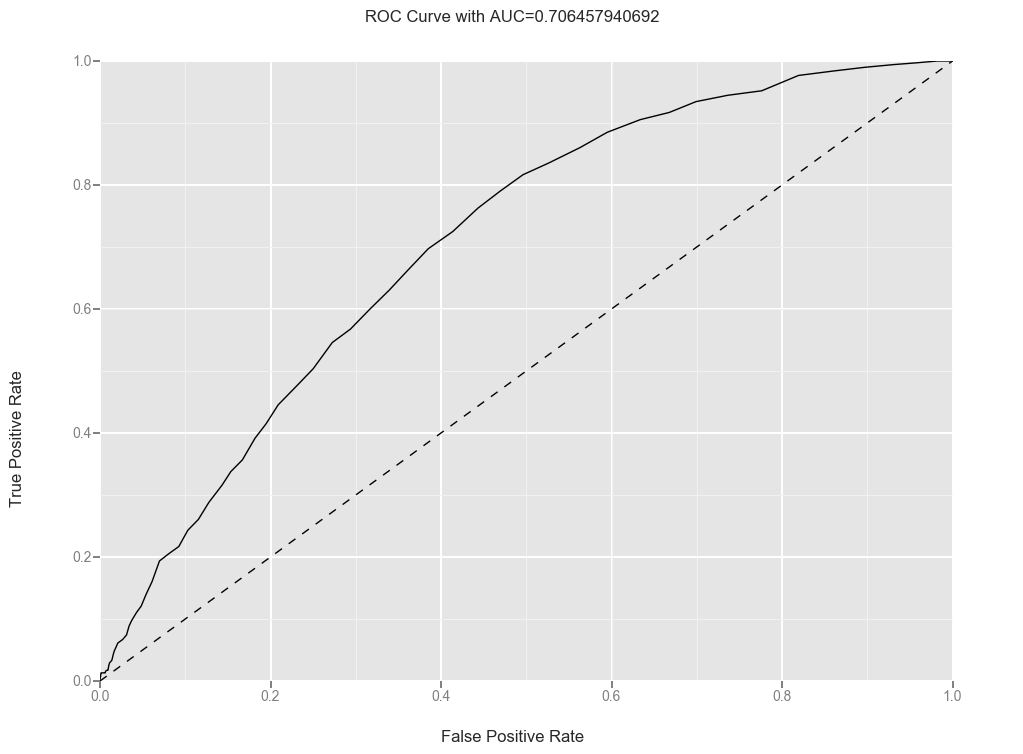

<ggplot: (291546481)>

In [14]:
# ROC Curve Plotting
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) +\
    geom_line() +\
    geom_abline(linetype='dashed') +\
    ggtitle('ROC Curve with AUC=%s' % str(auc)) +\
    xlab('False Positive Rate') + ylab('True Positive Rate')

The bowed shape of the ROC curve shows that **this model is pretty good at predicting which pitches will be fouled off!** The AUC score of 0.71 is quite good for a problem such as this. The model certainly performs much better than a random guess (indicated by the straight dashed line).

**So what features are important for determining whether a pitch is fouled off or not?** We can look into the results of our Random forest classifier to find out.

In [15]:
# Feature importances
colsX = pd.Series(X_test.columns.values)    # Grab names of the features
# Bring together feature names, and their importances in the model
imps = pd.concat([colsX, pd.Series(foulforest.feature_importances_)], axis=1).reset_index()
imps.columns = ['index', 'feature', 'importance']
imps.sort_values(by='importance', ascending=0)   # Sorted by importance

,index,feature,importance
19,19,pz,0.043879
18,18,px,0.039659
26,26,ay,0.039611
21,21,z0,0.039036
24,24,vz0,0.036852
20,20,x0,0.036799
17,17,pfx_z,0.036433
34,34,spin_rate,0.035848
31,31,type_conf,0.035331
33,33,spin_dir,0.035027


At the top, we find 'px' and 'pz', which represent the pitch location as it crosses the plate! **However, none of the individual features stand out as being especially strong at determining the pitch outcome.** Instead, it's the entirety of the pitch's features that, as a whole, affect the pitch outcome, rather than any one individual feature.

At the bottom of this list though, we do see that pitch types (fastball, slider, etc.) don't seem to matter too much, which is interesting. This is true across both common and rare pitch types.

## Conclusions

**We have a model that is 95% accurate at classifying pitches as fouls or not-fouls!**

However, the individual feature importance is not terribly informative. Location seems to matter to a small degree (px/pz).

It may help to delve into how each individual feature affects these pitch outcomes, but I wouldn't anticipate strong patterns. It seems like pitch outcomes can only be predicted based on a broad picture of all the features of a pitch, rather than any individual features.

**The importance of 'type_conf' is really interesting to me.** That feature is the PITCHf/x system's own confidence in classifying that pitch's type (Slider, Curveball, etc.). While that seems purely technical, **perhaps that confidence affects batters as well**, and their ability to react properly or make good contact. I would definitely like to look into this more, down the road.

And as mentioned earlier, it would be worthwhile to explore ways of encoding pitch sequences and pitch type sequences, but that is a difficult problem, to leave for later.

Even without them though, **we've successfully built a model that accurately predicts whether a pitch will be fouled off or not!**